# HHL Algorithm

Solving linear equations appears in many research, engineering, and design fields. For example, many physical and financial models, from fluid dynamics to portfolio optimization, are described by partial differential equations, which are typically treated by numerical schemes, most of which are eventually transformed to a set of linear equations.

The HHL algorithm [[1](#HHL)] is a quantum algorithm for solving a set of linear equations:
$$
A\vec{x} = \vec{b},
$$
represented by an $N\times N$ matrix $A$ and a vector $\vec{b}$ of size $N = 2^n$. The solution to the problem is designated by variable $\vec{x}$. The HHL is one of the fundamental quantum algorithms that is expected to give an exponential speedup over its classical counterpart*.

The algorithm estimates a quantum state $|x\rangle = |A^{-1}b\rangle$ from the initial quantum state $|b\rangle$, corresponding to $N$-dimensional vector $\vec{b}$. Estimation is done by inverting eigenvalues encoded in phases of eigenstates with use of Quantum Phase Estimation (QPE) and amplitude encoding.

The HHL algorithm treats the problem in the following way:

- **Input:** Hermitian matrix $A$ of size $2^n\times 2^n$, normalized vector $\vec{b}$, $|\vec{b}|=1$ and given precision $m$.
- **Promise:** Solution vector encoded in the state $|x\rangle = |A^{-1}b\rangle = \sum^{2^n-1}_{j=0} \frac{\beta_j}{\tilde{\lambda}_j} |u_j\rangle_n$, where:
 - $\lambda_j$ are eigenphases of a unitary $U = e^{2\pi i A}$, estimated up to $m$ binary digits and
 - $\beta_j$ are coefficients in expansion of initial state $|b\rangle$ into linear combination of eigenvectors of $A$, such that $|b\rangle = \sum^{2^n-1}_{j=0}\beta_j|u_j\rangle_n$.
- **Output:** Approximate solution $\vec{x}$.

More detailed description of the HHL algorithm is available in Technical Notes section, below.

For simplicity, the demo below treats a usecase where the matrix A has eigenvalues in the interval (0,1). Generalizations to other usecases, including the case where $|b|\neq 1$ and A is not an Hermitian matrix of size $2^n \times 2^n$, are discussed at the end of this demo.

***

\* The exponential speedup is in the sparsity of the Hermitian matrix $A$ and its [condition number](https://en.wikipedia.org/wiki/Condition_number). When $\kappa$ is the condition number of the Hermitian matrix $A$ and the eigenvalues of $A$ are in the interval $(\frac{1}{\kappa}, 1)$, the runtime of the HHL algorithm scales as $\kappa^2 \log(n) / \epsilon$, where $\epsilon$ is the additive error achieved in the output state $|x\rangle$. The algorithm achieves exponential speedup when both $\kappa$ and $1/\epsilon$ are $\text{poly} \log(n)$ (i.e., upper bounded by a polynomial expression with argument $\log(n)$) and the state $|b\rangle$ is loaded efficiently.


## Preliminaries

### Defining Matrix of a Specific Problem

In [1]:
import numpy as np

# Define matrix A
A = np.array(
    [
        [0.28, -0.01, 0.02, -0.1],
        [-0.01, 0.5, -0.22, -0.07],
        [0.02, -0.22, 0.43, -0.05],
        [-0.1, -0.07, -0.05, 0.42],
    ]
)

# Define RHS vector b
b = np.array([1, 2, 4, 3])

# Normalize vector b
b = b / np.linalg.norm(b)

print("A =", A, "\n")
print("b =", b)

# Verify if the matrix is symmetric and has eigenvalues in (0,1)
if not np.allclose(A, A.T, rtol=1e-6, atol=1e-6):
    raise Exception("The matrix is not symmetric")
w, v = np.linalg.eig(A)
for lam in w:
    if lam < 0 or lam > 1:
        raise Exception("Eigenvalues are not in (0,1)")

# Binary representation of eigenvalues (classically calculated)
m = 32  # Precision of a binary representation, e.g. 32 binary digits
sign = lambda num: "-" if num < 0 else ""  # Calculate sign of a number
binary = lambda fraction: str(
    np.binary_repr(int(np.abs(fraction) * 2 ** (m))).zfill(m)
).rstrip(
    "0"
)  # Binary representation of a fraction

print()
print("Eigenvalues:")
for eig in sorted(w):
    print(f"{sign(eig)}0.{binary(eig.real)} =~ {eig.real}")

A = [[ 0.28 -0.01  0.02 -0.1 ]
 [-0.01  0.5  -0.22 -0.07]
 [ 0.02 -0.22  0.43 -0.05]
 [-0.1  -0.07 -0.05  0.42]] 

b = [0.18257419 0.36514837 0.73029674 0.54772256]

Eigenvalues:
0.00110001001110101110101000011 =~ 0.19230521285666347
0.01000000011111000101001111001011 =~ 0.25189708445139913
0.01111110111101001101011001011011 =~ 0.4959234212146719
0.10110000100110111001100111010101 =~ 0.6898742814772653


### Define Hamiltonian

The unitary operator is essential for Quantum Phase Estimation (QPE) function code block and can be constructed directly from the Hamiltonian, representing given problem, defined by matrix $A$. Having the matrix or the Hamiltonian defined, the unitary operator can be created with the [`qpe_flexible`](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/classiq_open_library/qpe/qpe.ipynb) function by passing in the `unitary_with_power` argument a callable function that applies a unitary operation raised to a given power.


The built-in function `matrix_to_hamiltonian` encodes the matrix $A$ into a sum of Pauli strings, which then allows to encode the unitary matrix $U=e^{iA}$ with a product formula (Suzuki-Trotter). The number of qubits is stored in the variable `n`. This is a classical pre-processing that can be done with different methods of decomposition, for example you can compare with method described in [[2](#PauliDecomposition)].

In [2]:
from classiq import *

hamiltonian = matrix_to_hamiltonian(A)
n = len(hamiltonian[0].pauli)
print("Pauli strings list: \n")
for pterm in hamiltonian:
    print(pterm.pauli, ": ", np.round(pterm.coefficient, 3))

print("\nNumber of qubits for matrix representation =", n)

Pauli strings list: 

[<Pauli.I: 0>, <Pauli.I: 0>] :  0.408
[<Pauli.I: 0>, <Pauli.Z: 3>] :  -0.052
[<Pauli.Z: 3>, <Pauli.I: 0>] :  -0.017
[<Pauli.Z: 3>, <Pauli.Z: 3>] :  -0.057
[<Pauli.I: 0>, <Pauli.X: 1>] :  -0.03
[<Pauli.Z: 3>, <Pauli.X: 1>] :  0.02
[<Pauli.X: 1>, <Pauli.I: 0>] :  -0.025
[<Pauli.X: 1>, <Pauli.Z: 3>] :  0.045
[<Pauli.X: 1>, <Pauli.X: 1>] :  -0.16
[<Pauli.Y: 2>, <Pauli.Y: 2>] :  -0.06

Number of qubits for matrix representation = 2


## How to Build the Algorithm with Classiq

### The Quantum Part

#### Prepare Initial State for the Vector $\vec{b}$

The first step of the HHL algorithm is to load the elements of normalized RHS vector $\vec{b}$, into a quantum register:
$$
|0\rangle_n \xrightarrow[{\rm SP}]{} \sum^{2^n-1}_{i=0}b_i|i\rangle_n,
$$
where $|i\rangle$ are the states in computational basis.

Below, we define the quantum function `load_b` using the built-in function [`prepare_amplitudes`](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/qmod_core_library/prepare_state_and_amplitudes/prepare_state_and_amplitudes.ipynb). This function loads $2^n$ elements of the vector $\vec{b}$ into the `amplitudes` parameter and allows for setting an upper bound on the functional error with the `bound` argument. When we use the `load_b` function, the amplitudes of the state in the output register `state` will correspond to the values of the vector $\vec{b}$.


In [3]:
@qfunc
def load_b(
    amplitudes: CArray[CReal], state: Output[QArray[QBit]], bound: CReal
) -> None:
    prepare_amplitudes(amplitudes, bound, state)

#### Define HHL Quantum Function

The `hhl` function performs matrix eigenvalue inversion using flexible quantum phase estimation [`qpe_flexible`](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/classiq_open_library/qpe/qpe.ipynb), with the use of the [`within_apply`](https://docs.classiq.io/latest/qmod-reference/language-reference/statements/within-apply/) construct and the `simple_eig_inv` function. The latter function performs the eigenvalue inversion with [amplitude encoding assignment](https://docs.classiq.io/latest/qmod-reference/language-reference/statements/amplitude-encoding-assignment/) using the built-in construct designated by `*=`. For other supported statements, see [Numeric Assignment](https://docs.classiq.io/latest/qmod-reference/language-reference/statements/numeric-assignment/).

The `hhl` function returns normalized solution, by creating a state:
$$
\sum^{2^n-1}_{j=0}{\beta_j |\tilde{\lambda_j}\rangle_m |u_j\rangle_n \left(\sqrt{1-\frac{C^2}{\tilde{\lambda}^2_j}}|0\rangle_a + \frac{C}{\tilde{\lambda}_j}|1\rangle_a \right)} = \tilde{C} |{\rm garbage}\rangle|0\rangle + C |A^{-1}b\rangle|1\rangle,
$$

where $\tilde{C}$ and $|{\rm garbage}\rangle$ are irrelevant quantities, as the solution is entangled with the `indicator` output qubit at state $|1\rangle$. The state entangled with $|1\rangle$ stores the solution to the specific problem (up to the normalization coefficient):
$$
\sum^{2^n-1}_{j=0} \frac{C}{\lambda_j}\beta_j  \vec{\psi_j} = C|A^{-1}b\rangle = C|x\rangle.
$$

The normalization coefficient $C = \frac{1}{\Vert A^{-1}\vec{b}\Vert}$ has to be chosen with $O(1/\kappa)$, which ensures the amplitudes are normalized. However, here we can use the smallest eigenvalue approximation that the QPE can resolve $C = 1/2^{\rm precision}$, because it lower bounds the minimum eigenvalue.

**Arguments:**
- `unitary_with_power`: A callable function that applies a unitary operation raised to a power `k`.
- `precision`: An integer representing the precision of the phase estimation process (number of `phase` qubits).
- `state`: An array representing the initial quantum state $|b\rangle$ on which the matrix inversion is to be performed.
- `indicator`: An auxiliary qubit that stores result of the inversion and indicates if the phase qubits returns normalized solution.

In [4]:
from classiq.qmod.symbolic import floor, log

# Parameters for the initial state preparation
amplitudes = b.tolist()

# Parameters for the QPE
precision = 4


@qfunc
def simple_eig_inv(phase: QNum, indicator: Output[QBit]):
    allocate(1, indicator)
    C = 1 / 2**phase.size
    indicator *= C / phase


@qfunc
def hhl(
    rhs_vector: CArray[CReal],
    bound: CReal,
    precision: CInt,
    hamiltonian_evolution_with_power: QCallable[CInt, QArray[QBit]],
    state: Output[QArray[QBit]],
    phase: Output[QNum],
    indicator: Output[QBit],
):
    # Allocate a quantum number for the phase with given precision
    allocate_num(precision, False, precision, phase)

    # Prepare initial state
    load_b(amplitudes=amplitudes, state=state, bound=bound)

    # Perform quantum phase estimation and eigenvalue inversion within a quantum operation
    within_apply(
        lambda: qpe_flexible(
            unitary_with_power=lambda k: hamiltonian_evolution_with_power(k, state),
            phase=phase,
        ),
        lambda: simple_eig_inv(phase=phase, indicator=indicator),
    )

#### Set Execution Preferences

We prepare for the quantum program execution stage by providing execution details and constructing a representation of HHL model from a function defined in Quantum Modelling Language [Qmod](https://docs.classiq.io/latest/qmod-reference/). The resulting circuit is executed on a statevector simulator. For other available Classiq simulated backends see [Execution on Classiq simulators](https://docs.classiq.io/latest/user-guide/execution/cloud-providers/classiq-backends/).

To define this part of the model, we set the backend preferences by placing `ClassiqBackendPreferences` with the backend name `SIMULATOR_STATEVECTOR` into the `ExecutionPreferences`.

In [5]:
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)

backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)


# Construct a representation of HHL model
def hhl_model(main, backend_preferences):
    qmod_hhl = create_model(
        main,
        execution_preferences=ExecutionPreferences(
            num_shots=1, backend_preferences=backend_preferences
        ),
    )
    return qmod_hhl

### The Classical Postprocess

After running the circuit a given number of times and collecting measurement results from the ancillary and phase qubits we need to postprocess the data in order to find solution. Measurement values from circuit execution are denoted here by `res_hhl`.

We will create helper function `read_positions` that will return:
- `target_pos`: the position of the control qubit (ancilla) `indicator`,
- `sol_pos`: the positions of the solution register `res` and
- `phase_pos`: the positions of the phase qubits.

In [6]:
def read_positions(circuit_hhl, res_hhl):
    # positions of control qubit
    target_pos = res_hhl.physical_qubits_map["indicator"][0]

    # positions of solution
    sol_pos = list(res_hhl.physical_qubits_map["res"])

    # Finds the position of the "phase" register and flips for endianness, as you will use the indices to read directly from the string
    total_q = circuit_hhl.data.width  # total number of qubits of the whole circuit
    phase_pos = [
        total_q - k - 1 for k in range(total_q) if k not in sol_pos + [target_pos]
    ]
    return target_pos, sol_pos, phase_pos

#### Postselect Results

If all eigenvalues are $m$-estimated (are represented by $m$ binary digits), then eigenvalues uncomputation by inverse-QPE create the state:

$$
\sum^{2^n-1}_{j=0}{\beta_j |0\rangle_m |u_j\rangle_n \left(\sqrt{1-\frac{C^2}{\tilde{\lambda}^2_j}}|0\rangle_a + \frac{C}{\tilde{\lambda}_j}|1\rangle_a \right)}
$$

If at least one eigenvalue is not $m$-estimated, then after performing QPE$^\dagger$, the `phase` register is not reseted in $|0\rangle_m$.

In general case, we postselect only states that return 1 on ancillary qubit in `indicator` register. In this tutorial, we will add another postselection condition on `phase` register, to return $|0\rangle_m$, in order to increase accuracy of the solution result.

**Note:** Postselection can improve HHL algorithm results at the cost of more executions. In the future, when two-way quantum computing is utilized, postselection might be replaced by adjoint-state preparation, as envisioned by Jarek Duda [[4](#Duda)].

The `quantum_solution` function defines a run over all the relevant strings holding the solution. The solution vector will be inserted into the variable `qsol`, after normalizing with $C=1/2^m$.

In [7]:
def quantum_solution(circuit_hhl, res_hhl, precision):
    target_pos, sol_pos, phase_pos = read_positions(circuit_hhl, res_hhl)

    # Read Quantum solution from the entries of `res` registers, where the target register `indicator` is 1 and the `phase` register is in state |0>^m
    qsol = [
        np.round(parsed_state.amplitude / (1 / 2**precision), 5)
        for solution in range(2**n)
        for parsed_state in res_hhl.parsed_state_vector
        if parsed_state["indicator"] == 1.0
        and parsed_state["res"] == solution
        and [parsed_state.bitstring[k] for k in phase_pos] == ["0"] * precision
    ]

    return qsol

#### Compare Classical and Quantum Solutions

Note that the HHL algorithm returns a statevector result that includes an arbitrary global phase. The global phase can arise due to the transpilation process or from the intrinsic properties of the quantum functions themselves. Therefore, to compare with the classical solution, we need to correct the quantum results by the global phase (normalize). However, even after this normalization, there may still be a minus sign difference between the quantum and classical solutions, due to the inherent ambiguity of a global phase factor of $e^{i\pi}=-1$. The sign difference does not affect the physical validity of the comparison, as both states $|x\rangle$ and $-|x\rangle$ are considered equivalent in terms of their measurement probabilities.

In [8]:
import matplotlib.pyplot as plt


def quantum_solution_preprocessed(A, b, circuit_hhl, res_hhl, precision, disp=True):
    # Classical solution
    sol_classical = np.linalg.solve(A, b)
    if disp:
        print("Classical Solution:         ", sol_classical)

    # Quantum solution with postselection
    qsol = quantum_solution(circuit_hhl, res_hhl, precision)
    if disp:
        print("Quantum Solution:           ", np.abs(qsol) / np.linalg.norm(qsol))

    # Global phase from one element, e.g. qsol[0]
    global_phase = np.angle(qsol[0])

    # Preprocessed quantum solution
    qsol_corrected = np.real(qsol / np.exp(1j * global_phase))

    # Correct ambiguity in the sign
    qsol_corrected = (
        np.sign(qsol_corrected[0]) * np.sign(sol_classical[0]) * qsol_corrected
    )

    return sol_classical, qsol_corrected


def show_solutions(A, b, circuit_hhl, res_hhl, precision, check=True, disp=True):
    # Classical solution and preprocessed quantum solution
    sol_classical, qsol_corrected = quantum_solution_preprocessed(
        A, b, circuit_hhl, res_hhl, QPE_SIZE, disp=disp
    )

    # Verify is there is no functional error, which might come from changing endianness in Model or Execution
    if (
        np.linalg.norm(sol_classical - qsol_corrected) / np.linalg.norm(sol_classical)
        > 0.1
        and check
    ):
        raise Exception(
            "The HHL solution is too far from the classical one, please verify your algorithm"
        )

    if disp:
        print("Corrected Quantum Solution: ", qsol_corrected)

    # Fidelity
    state_classical = sol_classical / np.linalg.norm(sol_classical)
    state_corrected = qsol_corrected / np.linalg.norm(qsol_corrected)
    fidelity = np.abs(np.dot(state_classical, state_corrected)) ** 2
    print()
    print("Fidelity:                   ", f"{np.round(fidelity * 100,2)} %")

    if disp:
        plt.plot(sol_classical, "bo", label="Classical")
        plt.plot(qsol_corrected, "ro", label="HHL")
        plt.legend()
        plt.xlabel("$i$")
        plt.ylabel("$x_i$")
        plt.show()

In the upcoming sections, we will present two different examples of implementing Hamiltonian dynamics by defining the unitary operator using two methods: exact and approximated.

### Example: Exact Hamiltonian Evolution

While the implementation of exact Hamiltonian simulation provided here is not scalable for large systems due to the exponential growth in computational resources required, it serves as a valuable tool for debugging and studying small quantum systems.

In [9]:
from typing import List

import scipy

from classiq import Output, create_model, power, prepare_amplitudes, synthesize, unitary
from classiq.qmod.symbolic import floor, log

# Parameters for the initial state preparation
amplitudes = b.tolist()

# Parameters for the QPE
QPE_SIZE = 4


@qfunc
def unitary_with_power_logic(
    pw: CInt, matrix: CArray[CArray[CReal]], target: QArray[QBit]
) -> None:
    power(pw, lambda: unitary(elements=matrix, target=target))


@qfunc
def main(
    res: Output[QNum],
    phase: Output[QNum],
    indicator: Output[QBit],
) -> None:
    hhl(
        rhs_vector=amplitudes,
        bound=0,
        precision=QPE_SIZE,
        hamiltonian_evolution_with_power=lambda arg0, arg1: unitary_with_power_logic(
            matrix=scipy.linalg.expm(2 * np.pi * 1j * A).tolist(), pw=arg0, target=arg1
        ),
        state=res,
        phase=phase,
        indicator=indicator,
    )

In [10]:
# Construct HHL model
qmod_hhl_exact = hhl_model(main, backend_preferences)

In [11]:
from classiq import write_qmod

# Save qmod file
write_qmod(qmod_hhl_exact, "hhl_exact", decimal_precision=20)

#### Synthesizing the Model (exact)

In [12]:
qprog_hhl_exact = synthesize(qmod_hhl_exact)
show(qprog_hhl_exact)

circuit_hhl_exact = QuantumProgram.from_qprog(qprog_hhl_exact)
print("Circuit depth = ", circuit_hhl_exact.transpiled_circuit.depth)
print("Circuit CX count = ", circuit_hhl_exact.transpiled_circuit.count_ops["cx"])

Opening: https://platform.classiq.io/circuit/2uu0j7hKN9GATIicDfO3hFUVyvV?login=True&version=0.73.0
https://platform.classiq.io/circuit/2uu0j7hKN9GATIicDfO3hFUVyvV?login=True&version=0.73.0
Circuit depth =  464
Circuit CX count =  286


![png](figures/hhl_circuit.png)
<center>
<figcaption align = "middle">Synthesized HHL circuit</figcaption>
</center>

#### Statevector Simulation (exact)

Execute the quantum program. Recall that you chose a statevector simulator because you want the exact solution.

In [13]:
from classiq.execution import ExecutionDetails

res_hhl_exact = execute(qprog_hhl_exact).result_value()

In [14]:
qsol = quantum_solution(circuit_hhl_exact, res_hhl_exact, precision)
qsol

[(1.43559-0j), (2.56952-0j), (3.26897-0j), (2.48819-0j)]

#### Results (exact)

Classical Solution:          [1.3814374  2.50585064 3.19890483 2.43147877]
Quantum Solution:            [0.2840631  0.50843613 0.64683772 0.4923432 ]
Corrected Quantum Solution:  [1.43559 2.56952 3.26897 2.48819]

Fidelity:                    100.0 %


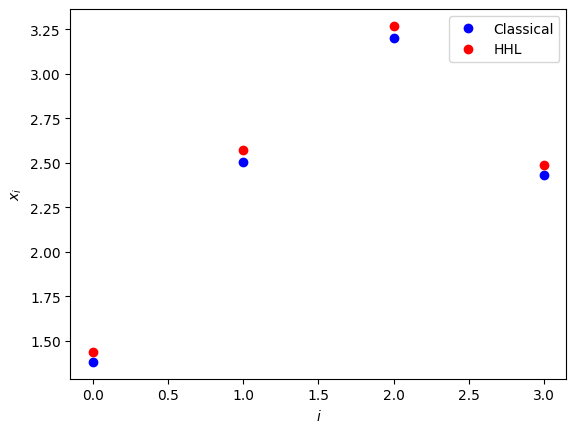

In [15]:
precision = QPE_SIZE
show_solutions(A, b, circuit_hhl_exact, res_hhl_exact, precision, check=False)

### Example: Approximated Hamiltonian Evolution (Suzuki-Trotter)

The approximated Hamiltonian simulation is capable of handling larger and more complex systems, making it more suitable for real-world applications where exact solutions are computationally prohibitive.

We will define the inner quantum call to be used within the flexible QPE: a Suzuki Trotter of order 1 [[3](#Trotter)], whose repetitions parameter grows by some constant factor proportional to the evolution coefficient.

For the QPE we are going to use Classiq's `suzuki-trotter` function of order 1 for Hamiltonian evolution $e^{-i H t}$. This function is an approximated one, where its `repetitions` parameter controls its error. For a QPE algorithm with size $m$ a series of controlled-unitaries $U^{2^s}$ $0 \leq s \leq m-1$ are applied, for each of which we would like to pass a different `repetitions` parameter depth (to keep a roughly same error, the repetitions for approximating $U=e^{2\pi i 2^s A }$ is expected to be $\sim 2^s$ larger then the repetitions of $U=e^{2\pi i A }$). In Classiq this can be done by working with a [`qpe_flexible`](https://github.com/Classiq/classiq-library/blob/main/functions/qmod_library_reference/classiq_open_library/qpe/qpe.ipynb), and passing a "rule" for how to exponentiate each step within the QPE in `repetitions` parameter.

In [16]:
from classiq.qmod.symbolic import ceiling, log


@qfunc
def suzuki_trotter1_with_power_logic(
    hamiltonian: CArray[PauliTerm],
    pw: CInt,
    r0: CInt,
    reps_scaling_factor: CReal,
    evolution_coefficient: CReal,
    target: QArray[QBit],
) -> None:
    suzuki_trotter(
        hamiltonian,
        evolution_coefficient=evolution_coefficient * pw,
        order=1,
        repetitions=r0 * ceiling(reps_scaling_factor ** (log(pw, 2))),
        qbv=target,
    )

The values of the parameters `R0` and `REPS_SCALING_FACTOR` below were chosen by trial and error because they are Hamiltonian dependent. For other examples, one would need to use different values for these parameters, please compare with specific example in [Flexible QPE tutorial](https://github.com/Classiq/classiq-library/blob/main/tutorials/advanced_tutorials/high_level_modeling_flexible_qpe/high_level_modeling_flexible_qpe.ipynb). The relevant literature that discusses the errors of product formulas is available in [[5](#trotter-error)].

In [17]:
from classiq.qmod.symbolic import floor

# parameters for the amplitude preparation
amplitudes = b.tolist()
SP_ERROR = 0.0

# parameters for the QPE
QPE_SIZE = 4

R0 = 4
REPS_SCALING_FACTOR = 1.8


@qfunc
def main(
    res: Output[QNum],
    phase: Output[QNum],
    indicator: Output[QBit],
) -> None:
    hhl(
        rhs_vector=amplitudes,
        bound=SP_ERROR,
        precision=QPE_SIZE,
        hamiltonian_evolution_with_power=lambda pw, target: suzuki_trotter1_with_power_logic(
            hamiltonian=hamiltonian,
            pw=pw,
            evolution_coefficient=-2 * np.pi,
            r0=R0,
            reps_scaling_factor=REPS_SCALING_FACTOR,
            target=target,
        ),
        state=res,
        phase=phase,
        indicator=indicator,
    )


# Define model
qmod_hhl_trotter = hhl_model(main, backend_preferences)

In [18]:
# Save qmod file
write_qmod(qmod_hhl_trotter, "hhl_trotter", decimal_precision=10)

Opening: https://platform.classiq.io/circuit/2uu0lbc9mZolTEWSfwgWJ3GWqVs?login=True&version=0.73.0
https://platform.classiq.io/circuit/2uu0lbc9mZolTEWSfwgWJ3GWqVs?login=True&version=0.73.0
Circuit depth =  5066
Circuit CX count =  2964



Classical Solution:          [1.3814374  2.50585064 3.19890483 2.43147877]
Quantum Solution:            [0.28600641 0.5107414  0.64756839 0.48785114]
Corrected Quantum Solution:  [1.4399586  2.54984965 3.2534983  2.43124679]

Fidelity:                    99.99 %


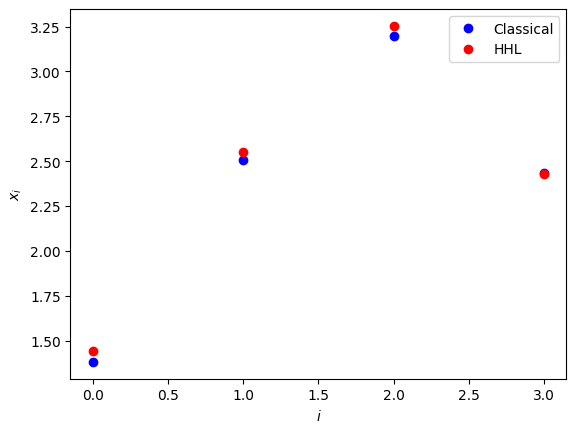

In [19]:
# Synthesize
qprog_hhl_trotter = synthesize(qmod_hhl_trotter)
show(qprog_hhl_trotter)

# Show circuit
circuit_hhl_trotter = QuantumProgram.from_qprog(qprog_hhl_trotter)
print("Circuit depth = ", circuit_hhl_trotter.transpiled_circuit.depth)
print("Circuit CX count = ", circuit_hhl_trotter.transpiled_circuit.count_ops["cx"])
print()

# Show results
res_hhl_trotter = execute(qprog_hhl_trotter).result_value()
show_solutions(A, b, circuit_hhl_trotter, res_hhl_trotter, precision)

We explored the HHL algorithm for solving linear systems using exact and approximated Hamiltonian simulations. The exact method, with a smaller circuit depth, is computationally less intensive but lacks scalability. In contrast, the approximated method, with a greater circuit depth, offers flexibility and can handle larger, more complex systems. This trade-off highlights the importance of choosing the right method based on problem size and complexity.

## 4. Generalizations

The usecase treated above is a canonical one, assuming the following properties:
- The RHS vector $\vec{b}$ is normalized.
- The matrix $A$ is an Hermitian one.
- The matrix $A$ is of size $2^n\times 2^n $.
- The eigenvalues of $A$ are in the range $(0,1)$.

However, any general problem that does not follow these conditions can be resolved as follows:

1) Normalize $\vec{b}$ and return the normalization factor

2) Symmetrize the problem as follows:
$$
\begin{pmatrix}
0 & A^T \\
A & 0
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
0  \\
\vec{x}
\end{pmatrix}.
$$
**Note:** This increases the number of qubits by 1.

3) Complete the matrix dimension to the closest $2^n$ with an identity matrix. The vector $\vec{b}$ will be completed with zeros.
$$
\begin{pmatrix}
A & 0 \\
0 & I
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
\vec{x}  \\
0
\end{pmatrix}.
$$

4) If the eigenvalues of $A$ are in the range $[-w_{\min},w_{\max}]$ you can employ transformations to the exponentiated matrix that enters into the Hamiltonian simulation, and then undo them for extracting the results:
$$
\tilde{A}=(A+w_{\min}I)\left(1-\frac{1}{2^{m}}\right)\frac{1}{w_{\min}+w_{\max}}.
$$
The eigenvalues of this matrix lie in the interval $[0,1)$, and are related to the eigenvalues of the original matrix via
$$
\lambda = (w_{\min}+w_{\max})\tilde{\lambda}\left[1/\left(1-\frac{1}{2^{n_{m}}}\right)\right]-w_{\min},
$$
with $\tilde{\lambda}$ being an eigenvalue of $\tilde{A}$ resulting from the QPE algorithm. This relation between eigenvalues is then used for the expression inserted into the eigenvalue inversion, via the `AmplitudeLoading` function.

## Technical Notes

A brief summary of the the HHL algorithm:

- **Preparation:** Unitary $U = e^{2\pi i A}$ is constructed out of matrix $A$ for exact or approximated Hamiltonian simulation.

- **Step 1:** Three registers are initialized of $m$, $n$ and 1 qubits respectively and vector $\vec{b}$ is encoded into initial state:
  $|0\rangle_m |0\rangle_n|0\rangle_a \xrightarrow[]{{\rm SP}} |0\rangle_m |b\rangle_n|0\rangle_a$.

- **Step 2:** Quantum Phase Estimation (QPE) with controlled powers of unitary $U$ is applied to the initial state,
  
  $\xrightarrow[]{{\rm QPE}} \sum^{2^n-1}_{j=0}\beta_j |\tilde{\lambda}_j\rangle_m |u_j\rangle_n |0\rangle_a$.

- **Step 3:** Controlled rotations are applied to auxiliary bit $|0\rangle_a$ with normalized constant $C = \frac{1}{2^m}$,

  $\xrightarrow[]{{\rm \lambda^{-1}}} \sum^{2^n-1}_{j=0}{\beta_j |\tilde{\lambda_j}\rangle_m |u_j\rangle_n \left(\sqrt{1-\frac{C^2}{\tilde{\lambda}^2_j}}|0\rangle_a + \frac{C}{\tilde{\lambda}_j}|1\rangle_a \right)}$.

- **Step 4:** Eigenvalues $|\tilde{\lambda_j}\rangle_m$ are uncomputed with QPE$^\dagger$,

  $\xrightarrow[]{{\rm QPE^\dagger}} \sum^{2^n-1}_{j=0}{\beta_j |0\rangle_m |u_j\rangle_n \left(\sqrt{1-\frac{C^2}{\tilde{\lambda}^2_j}}|0\rangle_a + \frac{C}{\tilde{\lambda}_j}|1\rangle_a \right)}$, if eigenvalues are $m$-estimated.

- **Step 5:** Auxiliary bit value is observed and if:

  - $|0\rangle_a$ is measured or
  - $|0\rangle_m$ is not measured,
  
  then return to step 0, otherwise observe the state $|x\rangle = \sum^{2^n-1}_{j=0} \frac{\beta_j}{\tilde{\lambda}_j} |u_j\rangle_n = |A^{-1}b\rangle$ and save measured results.

- **Step 6:** Repeat steps 1-5 for a fixed number of times ($s$-shots).

- **Step 7:** Collect solution from statistical processing $x_s$

- **Step 8:** Post-process and calculate approximate solution $x = {\rm Real} \left(\frac{x_s}{e^{i \phi}}\right)$, where $\phi$ is global phase of $x_s$.

## References

<a name='HHL'>[1]</a>: [Harrow, A. W., Hassidim, A., & Lloyd, S., Quantum Algorithm for Linear Systems of Equations. Physical Review Letters 103, 150502 (2009)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.150502).

<a name='PauliDecomposition'>[2]</a>: [L. Hantzko, L. Binkowski, S. Gupta, Tensorized Pauli decomposition algorithm (2024)](https://arxiv.org/abs/2310.13421).

<a name='Trotter'>[3]</a>: [N. Hatano, M. Suzuki, Finding Exponential Product Formulas of Higher Orders (2005)](https://arxiv.org/abs/math-ph/0506007).

<a name='Duda'>[4]</a>: [J.Duda, "Two-way quantum computers adding CPT analog of state preparation" (2023)](https://arxiv.org/abs/2308.13522).

<a name='trotter-error'>[5]</a>: [A. M. Childs, Y. Su, M. C. Tran, N. Wiebe, S. Zhu, "Theory of Trotter Error with Commutator Scaling" (2021)](https://arxiv.org/abs/2308.13522).
